In [6]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from numba import autojit

In [65]:
# Mask to select neighbours
mask = numpy.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])

class CA(object):
    def __init__(self, n=100, dt=0.1, max_step=1000):
        self.n = n
        
        # Max limit for energy
        self.maxenergy = 10
        
        # Energy
        self.energy = numpy.zeros([n, n])
        self.energy[1:n-1, 1:n-1] = 10
        self.allocated_energy = numpy.zeros([n, n])
        
        # Alpha
        self.alpha = numpy.zeros([n, n])
        self.alpha[1:n-1, 1:n-1] = numpy.random.uniform(0, 1, size=[n-2, n-2])
        self.allocated_alpha = numpy.zeros([n, n])
        
        # Beta
        self.beta = 1

        # Time
        self.t = 0
        self.dt = dt
        self.stepnum = 0
        
        # STATS
        self.STAT_alloc_energy = numpy.zeros(max_step)
        self.STAT_alloc_panels = numpy.zeros(max_step)
        self.STAT_total_active = numpy.zeros(max_step)
        self.STAT_total_energy = numpy.zeros(max_step)
    
    
    def step(self):
        # Time
        self.t = self.t + self.dt
        
        
        # Produce energy
        self.produce()
        
        # Allocate energy
        self.reallocate_energy()
        self.STAT_total_energy[self.stepnum] = numpy.sum(self.energy)
        
        # Consume energy
        self.consume()
        self.STAT_total_active[self.stepnum] = numpy.sum(self.energy>0)/(self.n-2)**2
        
        # Get dead neighbours' solar panels
        self.reallocate_panels()
        
        self.stepnum = self.stepnum + 1
        return self.energy
        
    def produce(self):
        self.energy = self.energy + self.alpha*(1+numpy.sin(self.t))
    
    def consume(self):
        self.energy = self.energy - self.beta
        self.energy[self.energy<0] = 0
        
    def reallocate_energy(self):
        # Allocation is uniform among the neighbours
        self.allocated_energy = numpy.zeros([self.n, self.n])
        for i in numpy.arange(1, self.n-1):
            for j in numpy.arange(1, self.n-1):
                if self.energy[i, j] > self.maxenergy:
                    alloc_e = self.energy[i, j] - self.maxenergy
                    # Number of active neighbours
                    n_neigh = numpy.sum(self.energy[i-1:i+2, j-1:j+2][mask==1] > 0)
                    # Alloctate energy among all neighbours
                    if n_neigh > 0:
                        if self.energy[i+1, j] > 0:
                            self.allocated_energy[i+1, j] += alloc_e/n_neigh
                        if self.energy[i-1, j] > 0:
                            self.allocated_energy[i-1, j] += alloc_e/n_neigh
                        if self.energy[i, j-1] > 0:
                            self.allocated_energy[i, j-1] += alloc_e/n_neigh
                        if self.energy[i, j+1] > 0:
                            self.allocated_energy[i, j+1] += alloc_e/n_neigh
      
                        # Stat
                        self.STAT_alloc_energy[self.stepnum] += alloc_e
                        
                    
        self.energy = self.energy + self.allocated_energy
        self.energy[self.energy>self.maxenergy] = self.maxenergy

    def reallocate_panels(self):
        self.allocated_alpha = numpy.zeros([self.n, self.n])
        # If it has only one neighbour, it takes all panels
        for i in numpy.arange(1, self.n-1):
            for j in numpy.arange(1, self.n-1):
                if self.energy[i, j] == 0:
                    # Number of active neighbours
                    n_neigh = numpy.sum(self.energy[i-1:i+2, j-1:j+2][mask==1] > 0)
                    # Alloctate solar panel capacity among neighbours
                    if n_neigh > 0:
                        if self.energy[i+1, j] > 0:
                            self.allocated_alpha[i+1, j] += self.alpha[i, j]/n_neigh
                        if self.energy[i-1, j] > 0:
                            self.allocated_alpha[i-1, j] += self.alpha[i, j]/n_neigh
                        if self.energy[i, j-1] > 0:
                            self.allocated_alpha[i, j-1] += self.alpha[i, j]/n_neigh
                        if self.energy[i, j+1] > 0:
                            self.allocated_alpha[i, j+1] += self.alpha[i, j]/n_neigh
                        
                        # Stat
                        
                        self.alpha[i, j] = 0
        self.STAT_alloc_panels[self.stepnum] = numpy.sum(self.allocated_alpha)
        self.alpha = self.alpha + self.allocated_alpha

In [66]:
c = CA(51, dt=0.2, max_step=100)

In [67]:
for i in range(100):
    c.step()

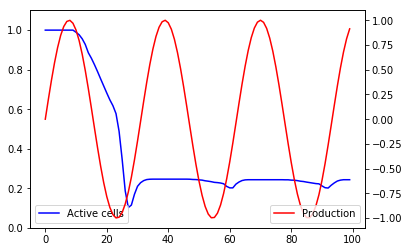

In [69]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(c.STAT_total_active, c='b', label='Active cells')
ax1.set_ylim([0, 1.1])
ax1.legend(loc=3)

ax2 = ax1.twinx()
ax2.plot(numpy.sin(numpy.linspace(0, c.t, num=100)), c='r', label='Production')
ax2.legend(loc=4)

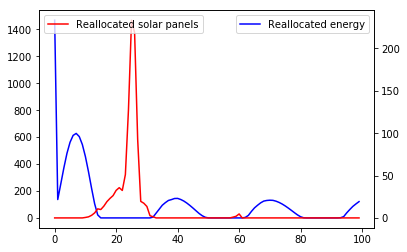

In [71]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(c.STAT_alloc_energy, c='b', label='Reallocated energy')
ax1.legend(loc=1)

ax2 = ax1.twinx()
ax2.plot(c.STAT_alloc_panels, c='r', label='Reallocated solar panels')
ax2.legend(loc=2)